In [243]:
using JuMP, GLPKMathProgInterface, Cbc, DataFrames, Plots, StatPlots, Random

In [315]:
function dados_e_plot(G, schedule_matrix, d, title, nplants, nmonths; alpha = 0.4, expected_value_of_demand = false, CVaR = zeros(1:nmonths))
    schedule = DataFrame(months = collect(1:nmonths), plants = [[] for i in 1:nmonths], capacity_available = [sum(G) for i in 1:nmonths])
    for plant in 1:nplants
        for month in 1:nmonths
            if schedule_matrix[plant, month] == 1
                push!(schedule.plants[month], plant)
                schedule.capacity_available[month] -= G[plant]
            end
        end
    end
    if length(size(d)) == 1
        return schedule, groupedbar([schedule.capacity_available d], title = title, label = ["capacity_available", "demand"], colour = [:blue :green])
    else
        plot = groupedbar([schedule.capacity_available d], title = title, label = ["capacity_available"; ["demand $i" for i in 1:size(d)[2]]; "expected_value_of_demand"], colour = reshape([:blue; [:green for i in 1:size(d)[2]]], 1, 1 + size(d)[2]), legend = false)
        if expected_value_of_demand
            bar!([sum(d[month, :]) / length(d[month, :]) for month in 1:nmonths], alpha = alpha, colour = :red, label = "expected_value_of_demand")
        end
        if sum(CVaR) != 0
            bar!(CVaR, alpha = alpha, colour = :red, label = "CVaR")
        end
        return schedule, plot
    end
end;

## 1.1 Heurística de solução para o problema de manutenção

Dado um conjunto de capacidades máximas $G_i$ de usinas $i$, a soma das capacidades das usinas que estão operando em um determinado mês é a capacidade disponível desse mês. Cada usina deve entrar em manutenção uma vez por ano. Deve-se distribuir as as paradas de manutenção das usinas durante um ano em uma agenda de manutenção, de modo que a $\textbf{menor das capacidades disponíveis dos meses seja maximizada}$.

A ideia neste caso é distribuir as doze usinas com maiores capacidades nos doze meses. A partir disso, distribuir as usinas restantes, cada uma, no mês que atualmente tem maior capacidade disponível.

In [316]:
function plants_in_a_year(G)
    capacity = sum(G)
    is = collect(range(1, stop = length(G)))
    G = collect(zip(is, G))
    sort!(G, by = G -> G[2], rev = true)
    months = [[month, capacity - G[plant][2], [G[plant][2]], [G[plant][1]]] for (month, plant) in zip(collect(1:12), shuffle(collect(1:12)))]
    G = copy(G[13:end])
    for plant in G
        sort!(months, by = month -> month[2], rev = true)
        push!(months[1][3], plant[2])
        push!(months[1][4], plant[1])
        months[1][2] -= plant[2]
    end
    sort!(months, by = month -> month[1])
    months = DataFrame(month = (month -> month[1]).(months), plants = (month -> month[4]).(months), capacity_available = (month -> month[2]).(months)) #, capacities_used = (month -> month[3]).(months))
    return months
end;

In [317]:
G1 = [10, 5, 20, 18, 23, 32, 7, 12, 10, 20, 17, 32, 12, 13, 7]
schedule1 = plants_in_a_year(G1)

,month,plants,capacity_available
,Int64,Array…,Int64
1,1,[12],206
2,2,"[13, 2]",221
3,3,[4],220
4,4,[6],206
5,5,[10],218
6,6,[11],221
7,7,[5],215
8,8,"[1, 7]",221
9,9,[8],226


## 1.2 Solução do problema de manutenção com otimização

In [318]:
G2 = [10, 5, 20, 18, 23, 32, 7, 12, 10, 20, 17, 32, 12, 13, 7]
d2 = [238, 220, 187, 175, 135, 127, 144, 165, 193, 205, 213, 233]
nplants2 = length(G2)
nmonths2 = length(d2);

In [319]:
m2 = Model(solver = CbcSolver())

@variable(m2, x[1:nplants2, 1:nmonths2], Bin)
@variable(m2, α)

#Toda usina desliga uma vez no ano
@constraintref constraints1[1:nplants2]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m2, sum(x[plant, 1:nmonths2]) >= 1)
end

#α deve ser maior do que todas as diferenças entre a capacidade disponível e a demanda do mês
@constraintref constraints2[1:nmonths2]
for month in eachindex(constraints2)
    constraints2[month] = @constraint(m2, α >= sum(G2 .* (1 .- x[1:nplants2, month])) - d2[month])
end

#A demanda sempre deve ser suprida
@constraintref constraints3[1:nmonths2]
for month in eachindex(constraints3)
    constraints3[month] = @constraint(m2, sum(G2 .* (1 .- x[1:nplants2, month])) - d2[month] >= 0)
end

@objective(m2, Min, α);

In [320]:
solve(m2)
@show getvalue(α)
schedule_matrix2 = getvalue(x)

getvalue(α) = 0.0


15×12 Array{Float64,2}:
 0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0
 0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0

In [321]:
dados2, plot2 = dados_e_plot(G2, schedule_matrix2, d2, "1.2 Solução do problema de manutenção com otimização", nplants2, nmonths2)
dados2

,months,plants,capacity_available
,Int64,Array…,Int64
1,1,[],238
2,2,[2],233
3,3,"[1, 8, 9, 13]",194
4,4,"[11, 12]",189
5,5,"[1, 3, 4, 9, 12]",148
6,6,"[1, 6, 9, 10, 12]",134
7,7,"[3, 4, 11, 12]",151
8,8,"[2, 3, 4, 9, 10]",165
9,9,"[1, 5, 8]",193


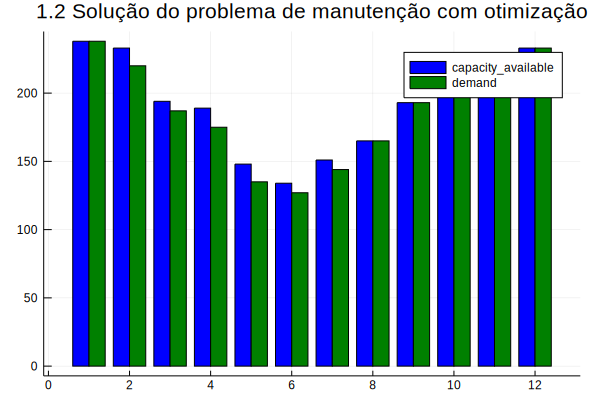

In [322]:
plot2

## 1.3 Potência disponível relativa ponderada pela demanda

In [323]:
G3 = [10, 5, 20, 18, 23, 32, 7, 12, 10, 20, 17, 32, 12, 13, 7]
d3 = [238, 220, 187, 175, 135, 127, 144, 165, 193, 205, 213, 233]
nplants3 = length(G3)
nmonths3 = length(d3);

In [324]:
m3 = Model(solver = CbcSolver())

@variable(m3, x[1:nplants3, 1:nmonths3], Bin)
@variable(m3, α)

#Toda usina desliga uma vez no ano
@constraintref constraints1[1:nplants3]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m3, sum(x[plant, 1:nmonths3]) >= 1)
end

#α deve ser maior do que todas as diferenças relativas entre a capacidade disponível e a demanda do mês
@constraintref constraints2[1:nmonths3]
for month in eachindex(constraints2)
    constraints2[month] = @constraint(m3, α >= (sum(G3 .* (1 .- x[1:nplants3, month])) - d3[month]) / d3[month])
end

#A demanda sempre deve ser suprida
@constraintref constraints3[1:nmonths3]
for month in eachindex(constraints3)
    constraints3[month] = @constraint(m3, sum(G3 .* (1 .- x[1:nplants3, month])) - d3[month] >= 0)
end

@objective(m3, Min, α);

In [325]:
solve(m3)
@show getvalue(α)
schedule_matrix3 = getvalue(x)

getvalue(α) = 0.0


15×12 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0
 0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0

In [326]:
dados3, plot3 = dados_e_plot(G3, schedule_matrix3, d3, "1.3 Potência disponível relativa ponderada pela demanda", nplants3, nmonths3)
dados3

,months,plants,capacity_available
,Int64,Array…,Int64
1,1,[],238
2,2,[2],233
3,3,"[6, 7, 8]",187
4,4,"[7, 11, 12, 15]",175
5,5,"[2, 3, 7, 10, 12, 13, 15]",135
6,6,"[2, 5, 7, 11, 12, 15]",147
7,7,"[4, 6, 12, 13]",144
8,8,"[1, 5, 9, 14]",182
9,9,"[5, 8]",203


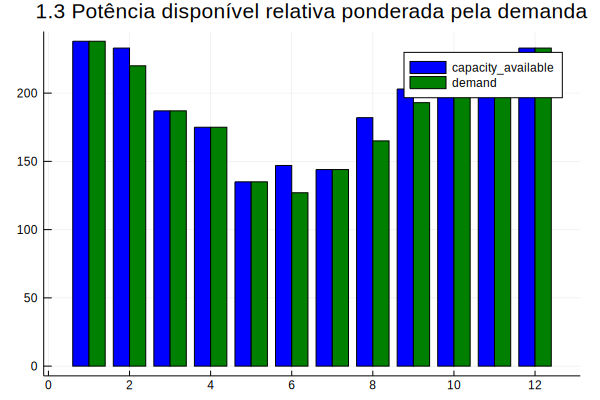

In [327]:
plot3

## 1.4 Restrição de potência disponível com margem de 10% da demanda

In [328]:
G4 = [10, 5, 20, 18, 23, 32, 7, 12, 10, 20, 17, 32, 12, 13, 7]
d4 = [238, 220, 187, 175, 135, 127, 144, 165, 193, 205, 213, 233]
C4_δ = 5
nplants4 = length(G4)
nmonths4 = length(d4);

In [329]:
m4 = Model(solver = CbcSolver())

@variable(m4, x[1:nplants4, 1:nmonths4], Bin)
@variable(m4, α)
@variable(m4, δ[1:nmonths4])

#Toda usina desliga uma vez no ano
@constraintref constraints1[1:nplants4]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m4, sum(x[plant, 1:nmonths4]) >= 1)
end

#α deve ser maior do que todas as diferenças relativas entre a capacidade disponível e a demanda do mês
@constraintref constraints2[1:nmonths4]
for month in eachindex(constraints2)
    constraints2[month] = @constraint(m4, α >= (sum(G4 .* (1 .- x[1:nplants4, month])) - d4[month]) / d4[month])
end

#Agora há uma variável pra que a margem da demanda possa não ser cumprida (com alto custo)
@constraintref constraints3[1:nmonths4]
for month in eachindex(constraints3)
    constraints3[month] = @constraint(m4, sum(G4 .* (1 .- x[1:nplants4, month])) + δ[month] >= 1.1 * d4[month])
end

@constraintref constraints4[1:nmonths4]
for month in eachindex(constraints4)
    constraints4[month] = @constraint(m4, 0 <= δ[month] <= 0.1 * d4[month])
end

@objective(m4, Min, α + sum(δ) * C4_δ);

In [330]:
solve(m4)
@show getvalue(α)
@show getvalue(δ)
schedule_matrix4 = getvalue(x)

getvalue(α) = 0.11737089201877927
getvalue(δ) = [23.8, 4.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 18.3]


15×12 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [331]:
dados4, plot4 = dados_e_plot(G4, schedule_matrix4, d4, "1.4 Restrição de potência disponível com margem de 10% da demanda", nplants4, nmonths4)
dados4

,months,plants,capacity_available
,Int64,Array…,Int64
1,1,[],238
2,2,[],238
3,3,"[3, 8]",206
4,4,"[12, 14]",193
5,5,"[2, 3, 6, 7, 11, 15]",150
6,6,"[1, 2, 4, 6, 12]",141
7,7,"[2, 9, 10, 12, 13]",159
8,8,"[1, 2, 4, 9, 13]",183
9,9,[5],215


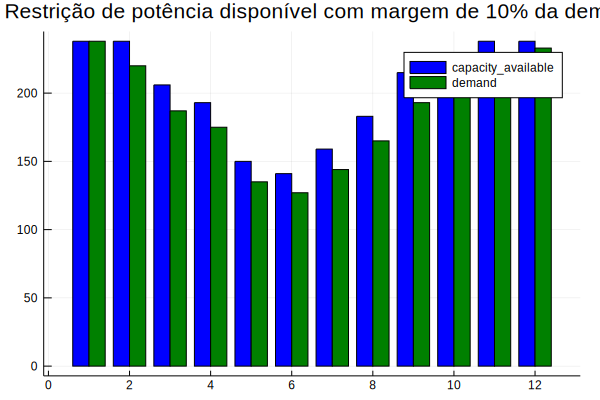

In [332]:
plot4

## 1.5 Utilizar cenários de demanda

### Valor esperado na função objetivo

In [374]:
G5 = [10, 5, 20, 18, 23, 32, 7, 12, 10, 20, 17, 32, 12, 13, 7]
d5_m = [238, 220, 187, 175, 135, 127, 144, 165, 193, 205, 213, 233]

#d5 = hcat(0.8 * d5_m, 0.9 * d5_m, d5_m, 1.0 * d5_m)
###
d5_m1 = [Int(round(d * 0.7)) for d in d5_m]
d5_m2 = [Int(round(d * (0.7 + 0.6 * rand()))) for d in d5_m1]
d5_m3 = [Int(round(d * (0.7 + 0.6 * rand()))) for d in d5_m1]
d5 = hcat(d5_m1, d5_m2, d5_m3)

Ns5 = size(d5)[2]
nplants5 = length(G5)
nmonths5 = length(d5_m);

In [375]:
m5 = Model(solver = CbcSolver())

@variable(m5, x[1:nplants5, 1:nmonths5], Bin)
@variable(m5, α[1:nmonths5, 1:Ns5])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants5]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m5, sum(x[plant, 1:nmonths5]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths5, 1:Ns5]
for month in 1:nmonths5
    for scenario in 1:Ns5
        constraints2[month, scenario] = @constraint(m5, sum(G5 .* (1 .- x[1:nplants5, month])) >= d5[month, scenario])
    end
end

@constraintref constraints3[1:nmonths5, 1:Ns5]
for month in 1:nmonths5
    for scenario in 1:Ns5
        constraints3[month, scenario] = @constraint(m5, α[month, scenario] >= sum(G5 .* (1 .- x[1:nplants5, month])) - d5[month, scenario])
    end
end

@objective(m5, Min, sum(sum(α[month, scenario] for scenario in 1:Ns5) / Ns5 for month in 1:nmonths5));

In [376]:
solve(m5)
@show getobjectivevalue(m5)
schedule_matrix5 = getvalue(x)

getobjectivevalue(m5) = 226.33333333333337


15×12 Array{Float64,2}:
 0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0
 0.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0
 0.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0
 0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0

In [377]:
dados5, plot5 = dados_e_plot(G5, schedule_matrix5, d5, "1.5 Utilizar cenários de demanda", nplants5, nmonths5, expected_value_of_demand = true)
dados5

,months,plants,capacity_available
,Int64,Array…,Int64
1,1,[4],220
2,2,"[4, 9]",210
3,3,"[1, 4, 5, 6]",155
4,4,"[1, 2, 5, 9, 13]",178
5,5,"[1, 4, 5, 6, 10, 11]",118
6,6,"[4, 6, 11, 12]",139
7,7,"[1, 5, 6, 8, 11]",144
8,8,"[1, 8, 9, 10, 12, 13]",142
9,9,"[4, 5, 6, 11]",148


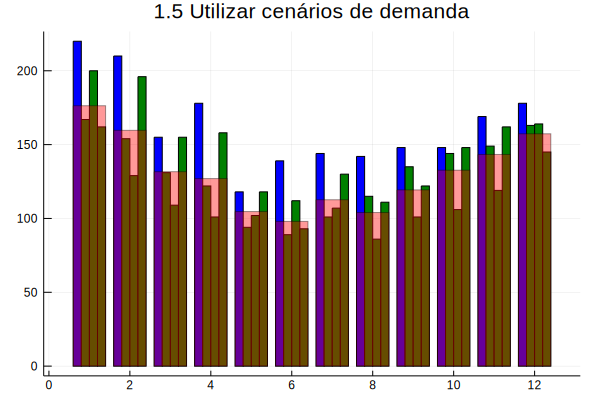

In [378]:
plot5

### Valor esperado na restrição

In [379]:
G5_2 = [10, 5, 20, 18, 23, 32, 7, 12, 10, 20, 17, 32, 12, 13, 7]
d5_2_m = [238, 220, 187, 175, 135, 127, 144, 165, 193, 205, 213, 233]

#d5 = hcat(0.8 * d5_m, 0.9 * d5_m, d5_m, 1.0 * d5_m)
###
d5_2_m1 = [Int(round(d * 0.7)) for d in d5_2_m]
d5_2_m2 = [Int(round(d * (0.7 + 0.6 * rand()))) for d in d5_2_m1]
d5_2_m3 = [Int(round(d * (0.7 + 0.6 * rand()))) for d in d5_2_m1]
d5_2 = hcat(d5_2_m1, d5_2_m2, d5_2_m3)

Ns5_2 = size(d5_2)[2]
nplants5_2 = length(G5_2)
nmonths5_2 = length(d5_2_m);

In [380]:
Ed5_2 = [sum(d5_2[month, :]) / 3 for month in 1:nmonths5_2];

In [381]:
m5_2 = Model(solver = CbcSolver())

@variable(m5_2, x[1:nplants5_2, 1:nmonths5_2], Bin)
@variable(m5_2, α[1:nmonths5_2])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants5_2]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m5_2, sum(x[plant, 1:nmonths5_2]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths5_2, 1:Ns5_2]
for month in 1:nmonths5_2
    for scenario in 1:Ns5_2
        constraints2[month, scenario] = @constraint(m5_2, sum(G5_2 .* (1 .- x[1:nplants5_2, month])) >= d5_2[month, scenario])
    end
end

@constraintref constraints3[1:nmonths5_2]
for month in 1:nmonths5_2
    constraints3[month] = @constraint(m5_2, α[month] >= sum(G5_2 .* (1 .- x[1:nplants5_2, month])) - Ed5_2[month])
end

@objective(m5_2, Min, sum(α));

In [382]:
solve(m5_2)
@show getobjectivevalue(m5_2)
schedule_matrix5_2 = getvalue(x)

getobjectivevalue(m5_2) = 117.66666666666667


15×12 Array{Float64,2}:
 1.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0
 0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  1.0  0.0
 0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0
 0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0
 1.0  1.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0
 0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0
 1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0
 1.0  1.0  1.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0

In [371]:
dados5_2, plot5_2 = dados_e_plot(G5_2, schedule_matrix5_2, d5_2, "1.5 Utilizar cenários de demanda", nplants5_2, nmonths5_2)
dados5_2

,months,plants,capacity_available
,Int64,Array…,Int64
1,1,"[1, 2, 4, 8]",193
2,2,"[5, 13]",203
3,3,"[2, 5, 8, 11, 13]",169
4,4,"[2, 4, 6, 8, 9]",161
5,5,"[2, 4, 5, 8, 9, 10, 11]",133
6,6,"[1, 3, 5, 8, 12, 13]",129
7,7,"[3, 5, 6, 9, 12]",121
8,8,"[1, 5, 8, 9, 10]",163
9,9,"[1, 2, 8, 9, 13]",189


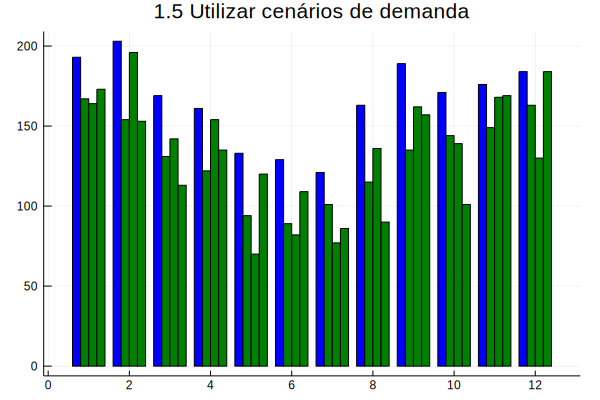

In [372]:
plot5_2

## 1.6 Utilizar cenários de renovável e demanda líquida

In [383]:
G6 = [10, 5, 20, 18, 23, 32, 7, 12, 10, 20, 17, 32, 12, 13, 7]
d6_m = [238, 220, 187, 175, 135, 127, 144, 165, 193, 205, 213, 233]
R6 = [33, 46, 98, 101, 102, 87, 88, 62, 42, 43, 27, 27]
d6_m = d6_m - R6

#d6 = hcat(0.8 * d6_m, 0.9 * d6_m, d6_m, 0.45 * d6_m)
###
d6_m1 = [Int(round(d * 0.7)) for d in d6_m]
d6_m2 = [Int(round(d * (0.7 + 0.6 * rand()))) for d in d6_m1]
d6_m3 = [Int(round(d * (0.7 + 0.6 * rand()))) for d in d6_m1]
d6 = hcat(d6_m1, d6_m2, d6_m3)

Ns6 = size(d6)[2]
nplants6 = length(G6)
nmonths6 = length(d6_m);

In [384]:
m6 = Model(solver = CbcSolver())

@variable(m6, x[1:nplants6, 1:nmonths6], Bin)
@variable(m6, α[1:Ns6])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants6]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m6, sum(x[plant, 1:nmonths6]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths6, 1:Ns6]
for month in 1:nmonths6
    for scenario in 1:Ns6
        constraints2[month, scenario] = @constraint(m6, sum(G6 .* (1 .- x[1:nplants6, month])) >= d6[month, scenario])
    end
end

@constraintref constraints3[1:nmonths6, 1:Ns6]
for month in 1:nmonths6
    for scenario in 1:Ns6
        constraints3[month, scenario] = @constraint(m6, α[scenario] >= sum(G6 .* (1 .- x[1:nplants6, month])) - d6[month, scenario])
    end
end

@objective(m6, Min, sum(α[scenario] for scenario in 1:Ns6) / Ns6);

In [385]:
solve(m6)
@show getvalue(α)
schedule_matrix6 = getvalue(x)

getvalue(α) = [37.0, 44.0, 59.0]


15×12 Array{Float64,2}:
 0.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0
 1.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0
 1.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
 0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0
 0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0
 1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0
 0.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0
 0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0
 1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0
 0.0  0.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  1.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0
 1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0
 1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0

In [386]:
dados6, plot6 = dados_e_plot(G6, schedule_matrix6, d6, "1.6 Utilizar cenários de renovável e demanda líquida", nplants6, nmonths6)
dados6

,months,plants,capacity_available
,Int64,Array…,Int64
1,1,"[2, 3, 8, 11, 13]",172
2,2,"[1, 3, 9, 11, 13]",169
3,3,"[1, 2, 4, 5, 6, 8, 9, 10, 13]",96
4,4,"[4, 5, 6, 8, 10, 11, 12]",84
5,5,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13]",59
6,6,"[1, 3, 4, 5, 6, 10, 11, 12]",66
7,7,"[1, 2, 3, 4, 5, 8, 10, 11, 12]",81
8,8,"[3, 5, 6, 11, 12, 13]",102
9,9,"[2, 3, 4, 5, 8, 10, 11, 13]",111


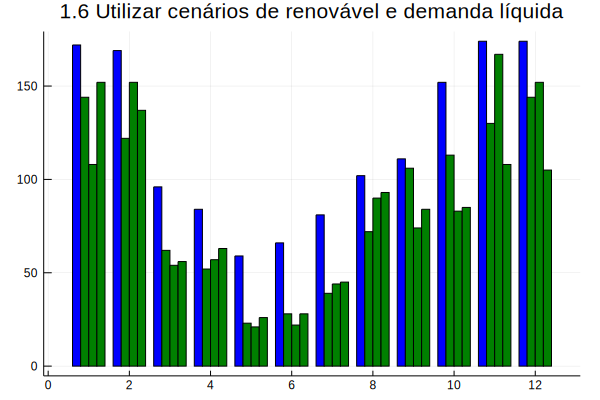

In [387]:
plot6

## 1.6.1 CVaR determinístico nas restrições

In [388]:
G6_1 = [10, 5, 20, 18, 23, 32, 7, 12, 10, 20, 17, 32, 12, 13, 7]
d6_1_m = [238, 220, 187, 175, 135, 127, 144, 165, 193, 205, 213, 233]
R6_1 = [33, 46, 98, 101, 102, 87, 88, 62, 42, 43, 27, 27]
θ6_1 = 0.7
d6_1_m = d6_1_m - R6_1

#d6_1 = hcat(0.1 * d6_1_m, 0.45 * d6_1_m, d6_1_m, 0.9 * d6_1_m)
###
d6_1_m1 = [Int(round(d * 0.7)) for d in d6_1_m]
d6_1_m2 = [Int(round(d * (0.7 + 0.6 * rand()))) for d in d6_1_m1]
d6_1_m3 = [Int(round(d * (0.7 + 0.6 * rand()))) for d in d6_1_m1]
d6_1 = hcat(d6_1_m1, d6_1_m2, d6_1_m3)

Ns6_1 = size(d6_1)[2]
nCVaR6_1 = Int(floor(θ6_1 * Ns6_1))
nplants6_1 = length(G6_1)
nmonths6_1 = length(d6_1_m);

In [389]:
CVaR_d6_1 = zeros(nmonths6_1)
for month in 1:nmonths6_1
    CVaR_d6_1[month] = sum(sort(d6_1[month, :])[(Ns6_1 - nCVaR6_1 + 1):Ns6_1]) / nCVaR6_1
end

In [395]:
m6_1 = Model(solver = CbcSolver())

@variable(m6_1, x[1:nplants6_1, 1:nmonths6_1], Bin)
@variable(m6_1, α)

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants6_1]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m6_1, sum(x[plant, 1:nmonths6_1]) >= 1)
end

#=@constraintref constraints2[1:nmonths6_1]
for month in 1:nmonths6_1
    constraints2[month] = @constraint(m6_1, sum(G6_1 .* (1 .- x[1:nplants6_1, month])) >= CVaR_d6_1[month])
end=#

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths6_1, 1:Ns6_1]
for month in 1:nmonths6_1
    for scenario in 1:Ns6_1
        constraints2[month, scenario] = @constraint(m6_1, sum(G6_1 .* (1 .- x[1:nplants6_1, month])) >= d6_1[month, scenario])
    end
end

@constraintref constraints3[1:nmonths6_1]
for month in eachindex(constraints3)
    constraints3[month] = @constraint(m6_1, α >= sum(G6_1 .* (1 .- x[1:nplants6_1, month])) - CVaR_d6_1[month])
end

@objective(m6_1, Min, α);

In [396]:
@show solve(m6_1)
@show getobjectivevalue(m6_1)
schedule_matrix6_1 = getvalue(x)

solve(m6_1) = :Optimal
getobjectivevalue(m6_1) = 15.000000000000004


15×12 Array{Float64,2}:
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0
 1.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0
 1.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  1.0
 0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0
 1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0
 1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0
 0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0
 1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0
 0.0  1.0  0.0  1.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  1.0
 0.0  0.0  1.0  1.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0
 1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0
 0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0
 0.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0

In [397]:
dados6_1, plot6_1 = dados_e_plot(G6_1, schedule_matrix6_1, d6_1, "1.6.1 CVaR determinístico nas restrições", nplants6_1, nmonths6_1, CVaR = CVaR_d6_1)
dados6_1

,months,plants,capacity_available
,Int64,Array…,Int64
1,1,"[2, 3, 4, 8, 10, 13]",151
2,2,"[1, 2, 3, 8, 9, 11]",164
3,3,"[1, 2, 3, 4, 6, 8, 9, 10, 12, 13]",67
4,4,"[1, 2, 3, 4, 5, 8, 9, 10, 11, 12]",71
5,5,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13]",59
6,6,"[1, 3, 4, 5, 6, 8, 10, 12]",71
7,7,"[1, 2, 3, 4, 5, 8, 10, 11, 12, 13]",69
8,8,"[1, 3, 6, 9, 10, 12, 13]",102
9,9,"[1, 3, 4, 8, 9, 10, 13]",136


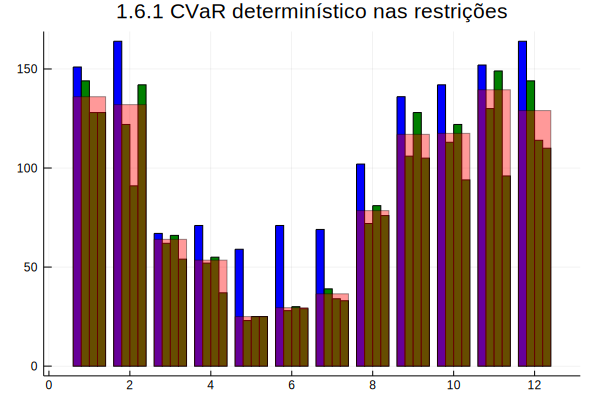

In [398]:
plot6_1

## 1.6.2 CVaR como problema de otimização na função objetivo

Um $\alpha$ para cada cenário

In [399]:
G6_2 = [10, 5, 20, 18, 23, 32, 7, 12, 10, 20, 17, 32, 12, 13, 7]
d6_2_m = [238, 220, 187, 175, 135, 127, 144, 165, 193, 205, 213, 233]
R6_2 = [33, 46, 98, 101, 102, 87, 88, 62, 42, 43, 27, 27]
θ6_2 = 0.4
d6_2_m = d6_2_m - R6_2

#d6_2 = hcat(0.1 * d6_2_m, 0.45 * d6_2_m, d6_2_m)
###
d6_2_m1 = [Int(round(d * 0.7)) for d in d6_2_m]
d6_2_m2 = [Int(round(d * (0.7 + 0.6 * rand()))) for d in d6_2_m1]
d6_2_m3 = [Int(round(d * (0.7 + 0.6 * rand()))) for d in d6_2_m1]
d6_2 = hcat(d6_2_m1, d6_2_m2, d6_2_m3)

Ns6_2 = size(d6_2)[2]
nplants6_2 = length(G6_2)
nmonths6_2 = length(d6_2_m);

In [400]:
m6_2 = Model(solver = CbcSolver())

@variable(m6_2, x[1:nplants6_2, 1:nmonths6_2], Bin)
@variable(m6_2, α[1:Ns6_2])
@variable(m6_2, z)
@variable(m6_2, δ[1:Ns6_2])

#Todas as usinas são desligadas pelo menos uma vez
@constraintref constraints1[1:nplants6_2]
for plant in eachindex(constraints1)
    constraints1[plant] = @constraint(m6_2, sum(x[plant, 1:nmonths6_2]) >= 1)
end

#Todas as demandas em todos os cenários são supridas
@constraintref constraints2[1:nmonths6_2, 1:Ns6_2]
for month in 1:nmonths6_2
    for scenario in 1:Ns6_2
        constraints2[month, scenario] = @constraint(m6_2, sum(G6_2 .* (1 .- x[1:nplants6_2, month])) >= d6_2[month, scenario])
    end
end

@constraintref constraints3[1:nmonths6_2, 1:Ns6_2]
for month in 1:nmonths6_2
    for scenario in 1:Ns6_2
        constraints3[month, scenario] = @constraint(m6_2, α[scenario] >= sum(G6_2 .* (1 .- x[1:nplants6_2, month])) - d6_2[month, scenario])
    end
end

@constraintref constraints4[1:Ns6_2]
for scenario in eachindex(constraints4)
    constraints4[scenario] = @constraint(m6_2, δ[scenario] <= z - α[scenario])
end

@constraintref constraints5[1:Ns6_2]
for scenario in eachindex(constraints5)
    constraints5[scenario] = @constraint(m6_2, δ[scenario] <= 0)
end

#@expression(m6_2, C, z - sum(1 / Ns6_2 * δ[scenario] / (1 - θ6_2) for scenario in 1:Ns6_2))

@objective(m6_2, Min, z - sum(1 / Ns6_2 * δ[scenario] / (1 - θ6_2) for scenario in 1:Ns6_2));

In [401]:
@show solve(m6_2)
@show getvalue(α)
@show getvalue(z)
@show getvalue(δ)
schedule_matrix6_2 = getvalue(x)

solve(m6_2) = :Optimal
getvalue(α) = [43.0, 36.0, 51.0]
getvalue(z) = 43.000000000000014
getvalue(δ) = [0.0, 0.0, -8.0]


15×12 Array{Float64,2}:
 0.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  1.0  1.0  0.0  1.0  0.0  1.0  0.0  1.0  1.0  0.0  1.0
 1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0
 0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0
 0.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0
 0.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0
 0.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  1.0  1.0  0.0
 0.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0
 1.0  1.0  1.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  0.0  1.0
 0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0
 1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0

In [402]:
dados6_2, plot6_2 = dados_e_plot(G6_2, schedule_matrix6_2, d6_2, "1.6.2 CVaR como problema de otimização na função objetivo", nplants6_2, nmonths6_2)
dados6_2

,months,plants,capacity_available
,Int64,Array…,Int64
1,1,"[3, 8, 13, 15]",187
2,2,"[1, 2, 7, 9, 11, 13, 14]",164
3,3,"[1, 2, 4, 5, 6, 7, 8, 9, 10, 13, 15]",82
4,4,"[1, 3, 4, 5, 6, 9, 10, 11]",88
5,5,"[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 13, 14]",46
6,6,"[1, 3, 4, 5, 6, 7, 11, 12, 14]",66
7,7,"[1, 2, 3, 4, 5, 7, 10, 11, 12, 14, 15]",66
8,8,"[3, 5, 7, 8, 9, 11, 12, 13, 14]",92
9,9,"[2, 3, 4, 5, 8, 10, 13]",128


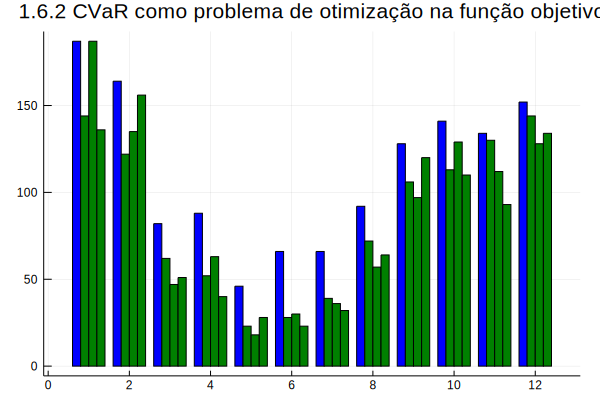

In [403]:
plot6_2